## Прогнозирование спроса
Краткое описание:
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.

Задача:
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

Метрика качества:
`WAPE:
def wape(y_true: np.array, y_pred: np.array):
return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))`

1) sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
3) pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

### Загрузка-библиотек

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from phik.report import plot_correlation_matrix
warnings.filterwarnings('ignore')

### EDA

In [2]:
sales_df_train = pd.read_csv('sp_sales_task/sales_df_train.csv', parse_dates=['date'])
shops = pd.read_csv('sp_sales_task/st_df.csv')
products = pd.read_csv('sp_sales_task/pr_df.csv')
holiday = pd.read_csv('holidays_covid_calendar.csv')

In [3]:
sales_df_train_2 = sales_df_train.copy()

In [4]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


In [5]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [7]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [8]:
holiday = holiday[['date', 'holiday']]
holiday['date'] = pd.to_datetime(holiday['date'], format='%d.%m.%Y')

In [9]:
sales_df_train = sales_df_train.merge(holiday, on='date', how='left')
sales_df_train.sample()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday
572847,1ecfb463472ec9115b10c292ef8bc986,131539d99ac196766086b57c1119b7de,2023-02-02,0,1.0,0.0,360.0,0.0,0


Уникальное количество товаров

In [10]:
len(sales_df_train['pr_sku_id'].unique())

1991

Уникальное количество магазинов

In [11]:
len(sales_df_train['st_id'].unique())

12

Вывод: Дубликатов и пропусков не обнаружено.

#### Объединение датафреймов

Объединим данные по магазинам и товарам в одну таблицу для выведения активных магазинов

In [12]:
total = sales_df_train.merge(shops, on='st_id', how='left').merge(products, on='pr_sku_id', how='left')
index_no_active = total.index[total['st_is_active']== 0].tolist()

#### Нулевые значения в целевом признаке

In [13]:
total = total.drop(index=index_no_active)
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882286 entries, 0 to 883014
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    882286 non-null  object        
 1   pr_sku_id                882286 non-null  object        
 2   date                     882286 non-null  datetime64[ns]
 3   pr_sales_type_id         882286 non-null  int64         
 4   pr_sales_in_units        882286 non-null  float64       
 5   pr_promo_sales_in_units  882286 non-null  float64       
 6   pr_sales_in_rub          882286 non-null  float64       
 7   pr_promo_sales_in_rub    882286 non-null  float64       
 8   holiday                  882286 non-null  int64         
 9   st_city_id               882286 non-null  object        
 10  st_division_code         882286 non-null  object        
 11  st_type_format_id        882286 non-null  int64         
 12  st_type_loc_id       

In [14]:
sales_units_zero = total[total['pr_sales_in_units'] == 0]
print(
    'нулевые продажи в шт и руб:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2), '%'
)
print(
    'нулевые продажи в шт, но не нулевые в рублях:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2), '%'
)

нулевые продажи в шт и руб: 453 
их доля в данных: 0.05 %
нулевые продажи в шт, но не нулевые в рублях: 66089 
их доля в данных: 7.49 %


В данных имеются записи, которые можно удалить (их доля 7.53%): нулевые значения в количестве проданных товаров и их стоимости

In [15]:
total = total.loc[total['pr_sales_in_units'] != 0]

#### Отрицательные значения в целевом признаке

In [16]:
print(
    'количество записей возвратов:', 
    total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(), 
    '\nих доля в данных:', 
    round(total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / total['pr_sales_in_units'].count() * 100, 2), '%'
)

количество записей возвратов: 71 
их доля в данных: 0.01 %


Удаление записей возврата

In [17]:
total = total.loc[total['pr_sales_in_units'] > 0]
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815673 entries, 0 to 883014
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815673 non-null  object        
 1   pr_sku_id                815673 non-null  object        
 2   date                     815673 non-null  datetime64[ns]
 3   pr_sales_type_id         815673 non-null  int64         
 4   pr_sales_in_units        815673 non-null  float64       
 5   pr_promo_sales_in_units  815673 non-null  float64       
 6   pr_sales_in_rub          815673 non-null  float64       
 7   pr_promo_sales_in_rub    815673 non-null  float64       
 8   holiday                  815673 non-null  int64         
 9   st_city_id               815673 non-null  object        
 10  st_division_code         815673 non-null  object        
 11  st_type_format_id        815673 non-null  int64         
 12  st_type_loc_id       

#### Проанализируем целевую переменную `pr_sales_in_units`

In [18]:
total['pr_sales_in_units'].describe()

count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

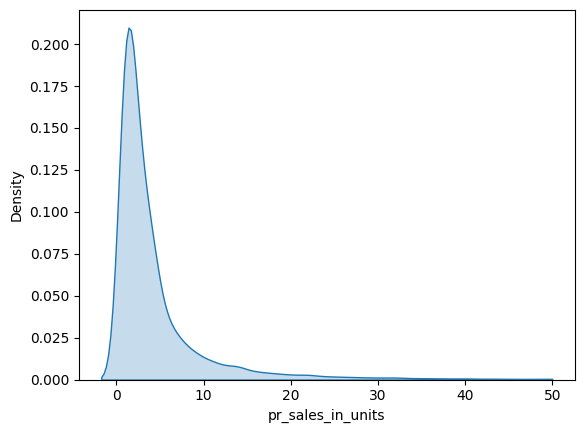

In [19]:
sns.kdeplot(total, x='pr_sales_in_units', clip=(-10, 50), fill=True);

Cреднее значение больше медианного, наблюдается правосторонняя асимметрия. Распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### Корреляция между категориальными признаками

In [20]:
categ_cols = [
    'st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code', 
    'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_is_active', 
    'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id', 'holiday'
    ]
phik_overview = total[categ_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_type_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_is_active', 'pr_uom_id', 'holiday']


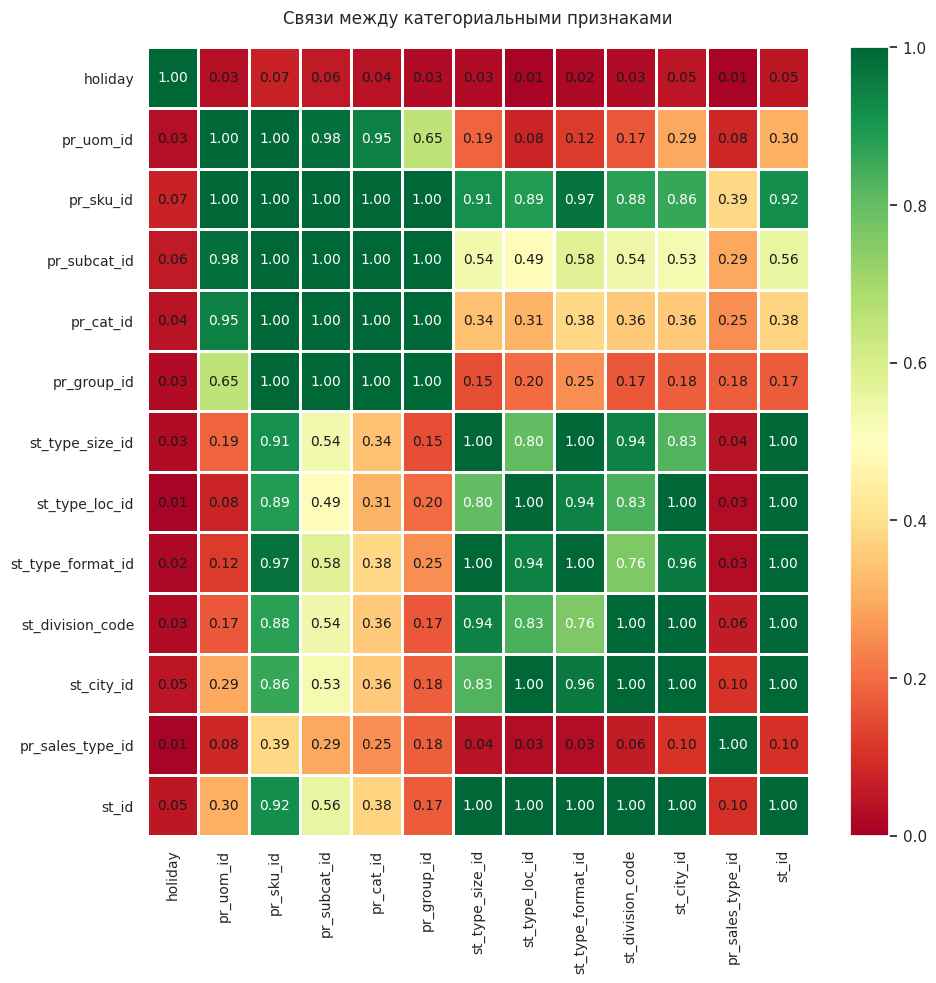

In [21]:
sns.set()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(10, 10))

plt.title('Связи между категориальными признаками', fontsize=12, y=1.02)
plt.tight_layout()

Наблюдается сильная зависимость между категориальными признаками, что вполне логично.
Удаление зависимых признаков.

In [22]:
quant_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
phik_overview_q = total[quant_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']


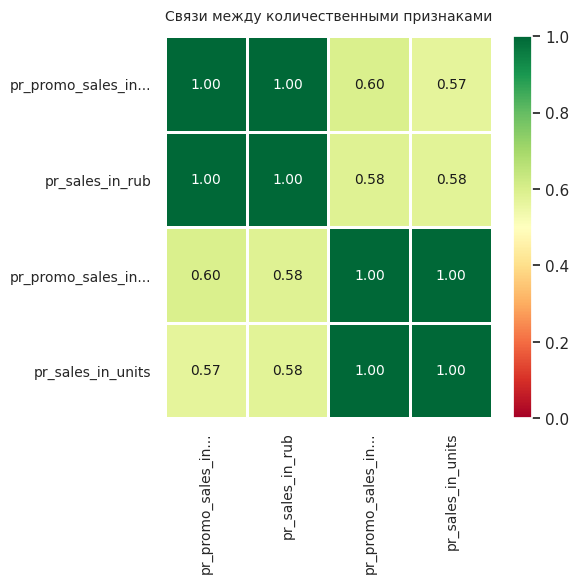

In [23]:
sns.set()
plot_correlation_matrix(phik_overview_q.values, 
                        x_labels=phik_overview_q.columns, 
                        y_labels=phik_overview_q.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(6, 6))

plt.title('Связи между количественными признаками', fontsize=10, y=1.02)
plt.tight_layout()

Высокая корреляция наблюдается у признаков:
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_units`
- `pr_promo_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_sales_in_rub` и `pr_promo_sales_in_rub`
    
Средняя корреляция наблюдается у признаков:

- Целевой признак `pr_sales_in_units` и `pr_sales_in_rub`
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_promo_sales_in_units` и `pr_sales_in_rub`

Удалим сильно коррелированные столбцы

In [24]:
total = total.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

#### Распределение целевого признака между выходными и буднями

In [25]:
holiday_1_units = total[total['holiday'] == 1]['pr_sales_in_units'].sum()
holiday_0_units = total[total['holiday'] == 0]['pr_sales_in_units'].sum()
holiday_1_rub = total[total['holiday'] == 1]['pr_sales_in_rub'].sum()
holiday_0_rub =  total[total['holiday'] == 0]['pr_sales_in_rub'].sum()

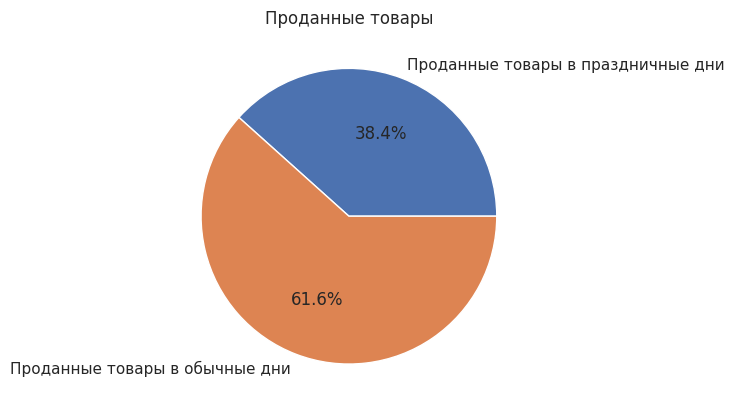

In [26]:
labels = 'Проданные товары в праздничные дни', 'Проданные товары в обычные дни'
sizes = [holiday_1_units, holiday_0_units]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Проданные товары')
plt.show()

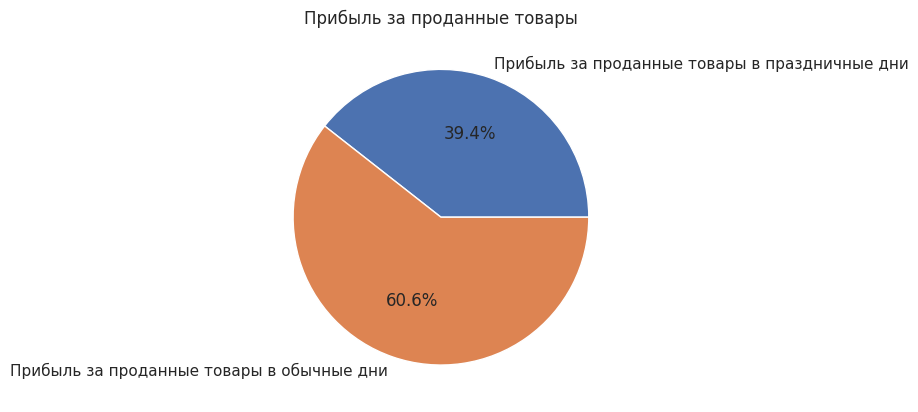

In [27]:
labels = 'Прибыль за проданные товары в праздничные дни', 'Прибыль за проданные товары в обычные дни'
sizes = [holiday_1_rub, holiday_0_rub]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Прибыль за проданные товары')
plt.show()

#### Распределение целевого признака по датам

In [29]:
total=total.set_index('date')

KeyError: "None of ['date'] are in the columns"

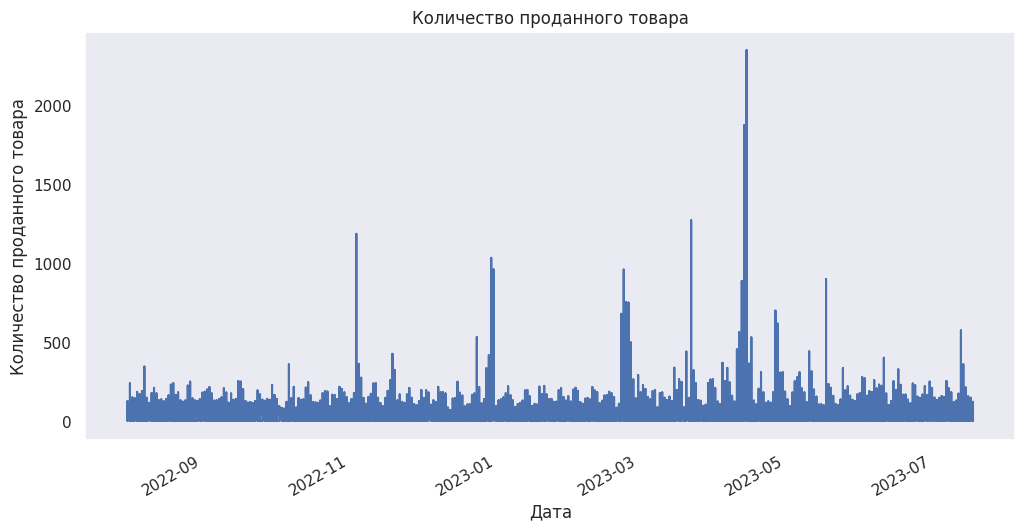

In [31]:
total['pr_sales_in_units'].plot(figsize=(12,6));
plt.title("Количество проданного товара") 
plt.xlabel("Дата") 
plt.ylabel("Количество проданного товара") 
plt.grid();

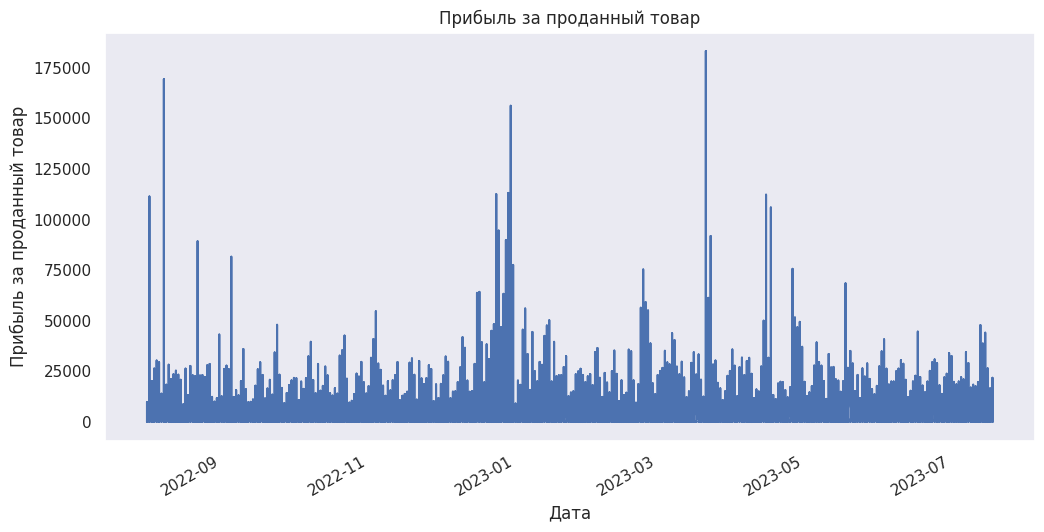

In [32]:
total['pr_sales_in_rub'].plot(figsize=(12,6));
plt.title("Прибыль за проданный товар") 
plt.xlabel("Дата") 
plt.ylabel("Прибыль за проданный товар") 
plt.grid();

#### Скользящее среднее

In [33]:
total['mean']  = total['pr_sales_in_units'].rolling(15).mean()

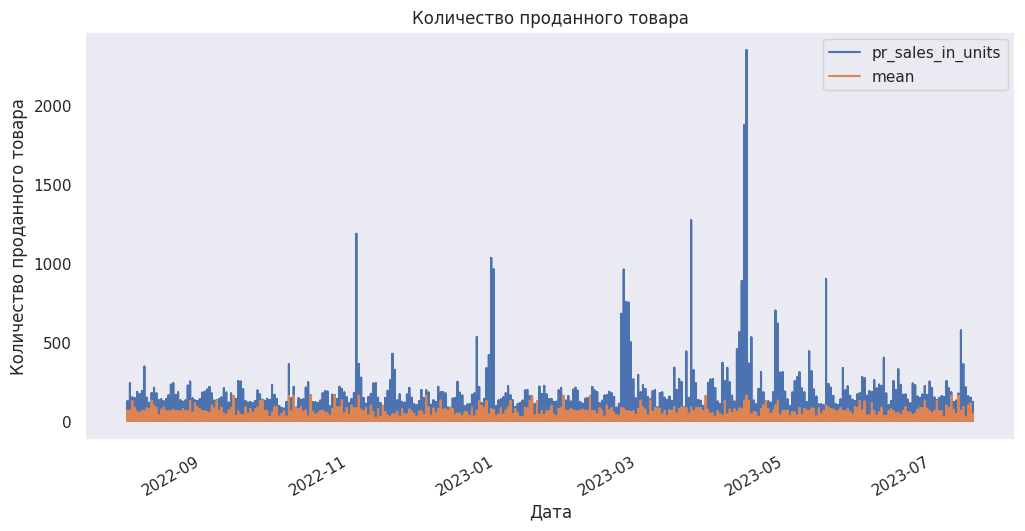

In [34]:
total['pr_sales_in_units'].plot(figsize=(12,6));
total['mean'].plot(figsize=(12,6));
plt.title("Количество проданного товара") 
plt.xlabel("Дата") 
plt.ylabel("Количество проданного товара") 
plt.grid()  
plt.legend(); 

In [35]:
total = total.drop(columns=['mean'])

#### Resampling по суммарным значениям за день

In [36]:
total = total.resample('1D').sum()

#### Графики среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [37]:
columns = ['pr_sales_in_units', 'pr_sales_in_rub']

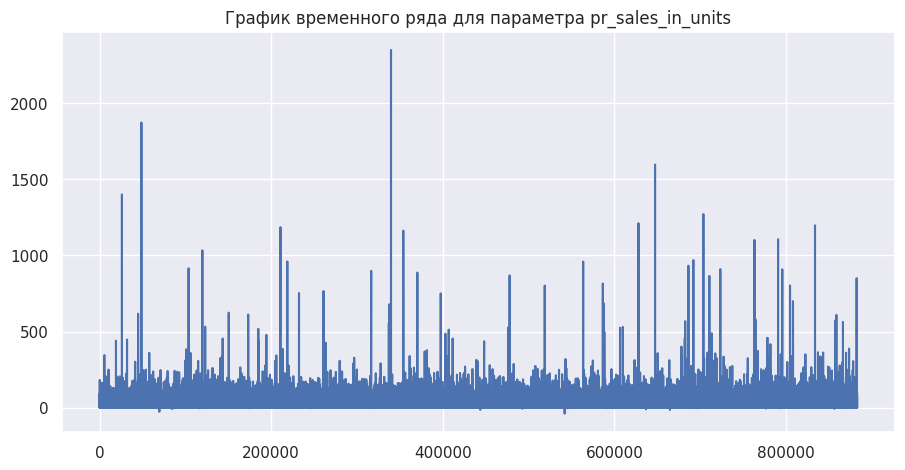

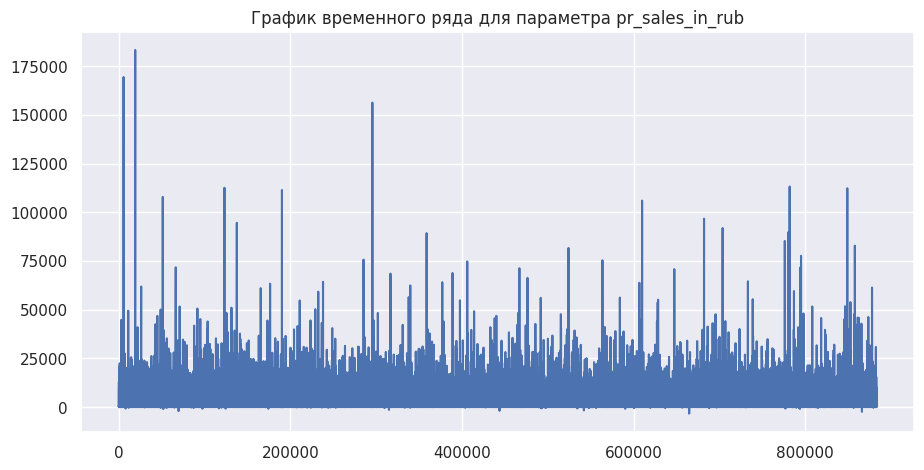

In [38]:
for num in columns:
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(121)
    plot1 = sales_df_train[num].plot(title= 'График временного ряда для параметра ' +  num)
    plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
    plt.show()

#### Графики скользящего среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [44]:
total['rolling_mean_units'] = total['pr_sales_in_units'].rolling(10).mean()
total['rolling_mean_rub'] = total['pr_sales_in_rub'].rolling(10).mean()

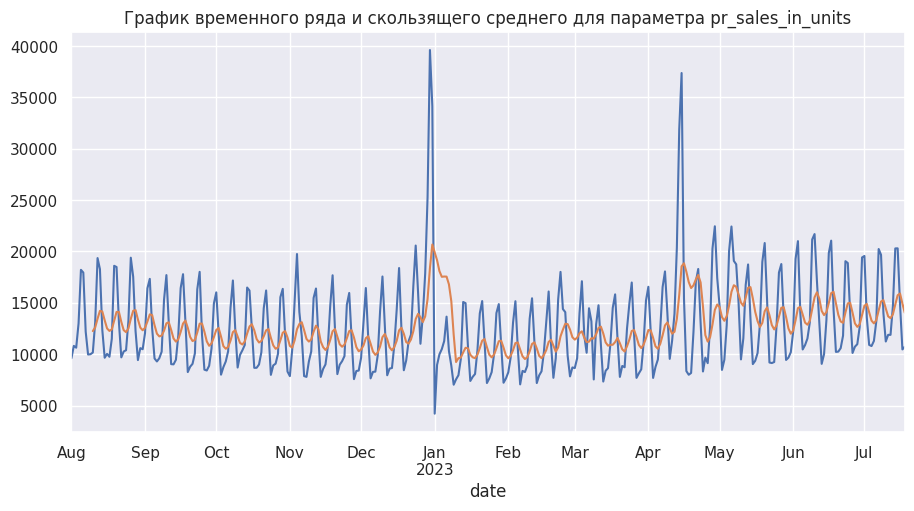

In [45]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_units'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_units')
plot2 = total['rolling_mean_units'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

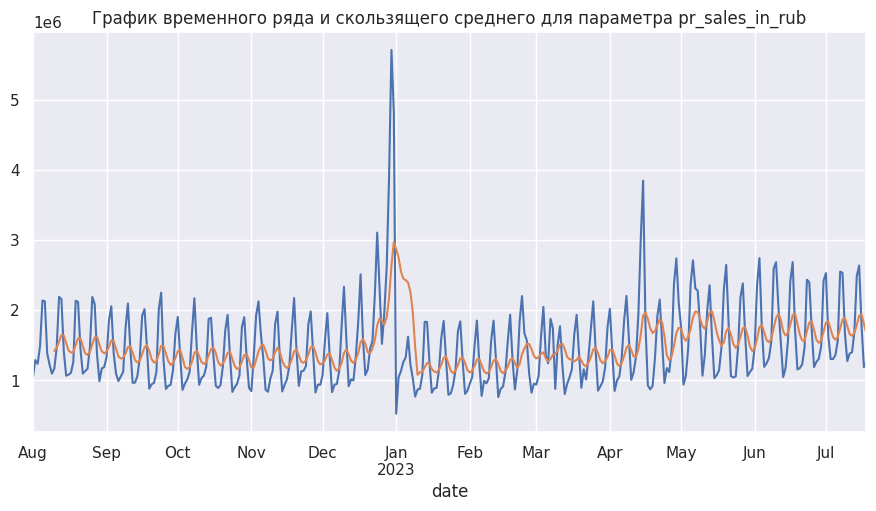

In [46]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_rub'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_rub')
plot2 = total['rolling_mean_rub'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

#### Изучение сезонности

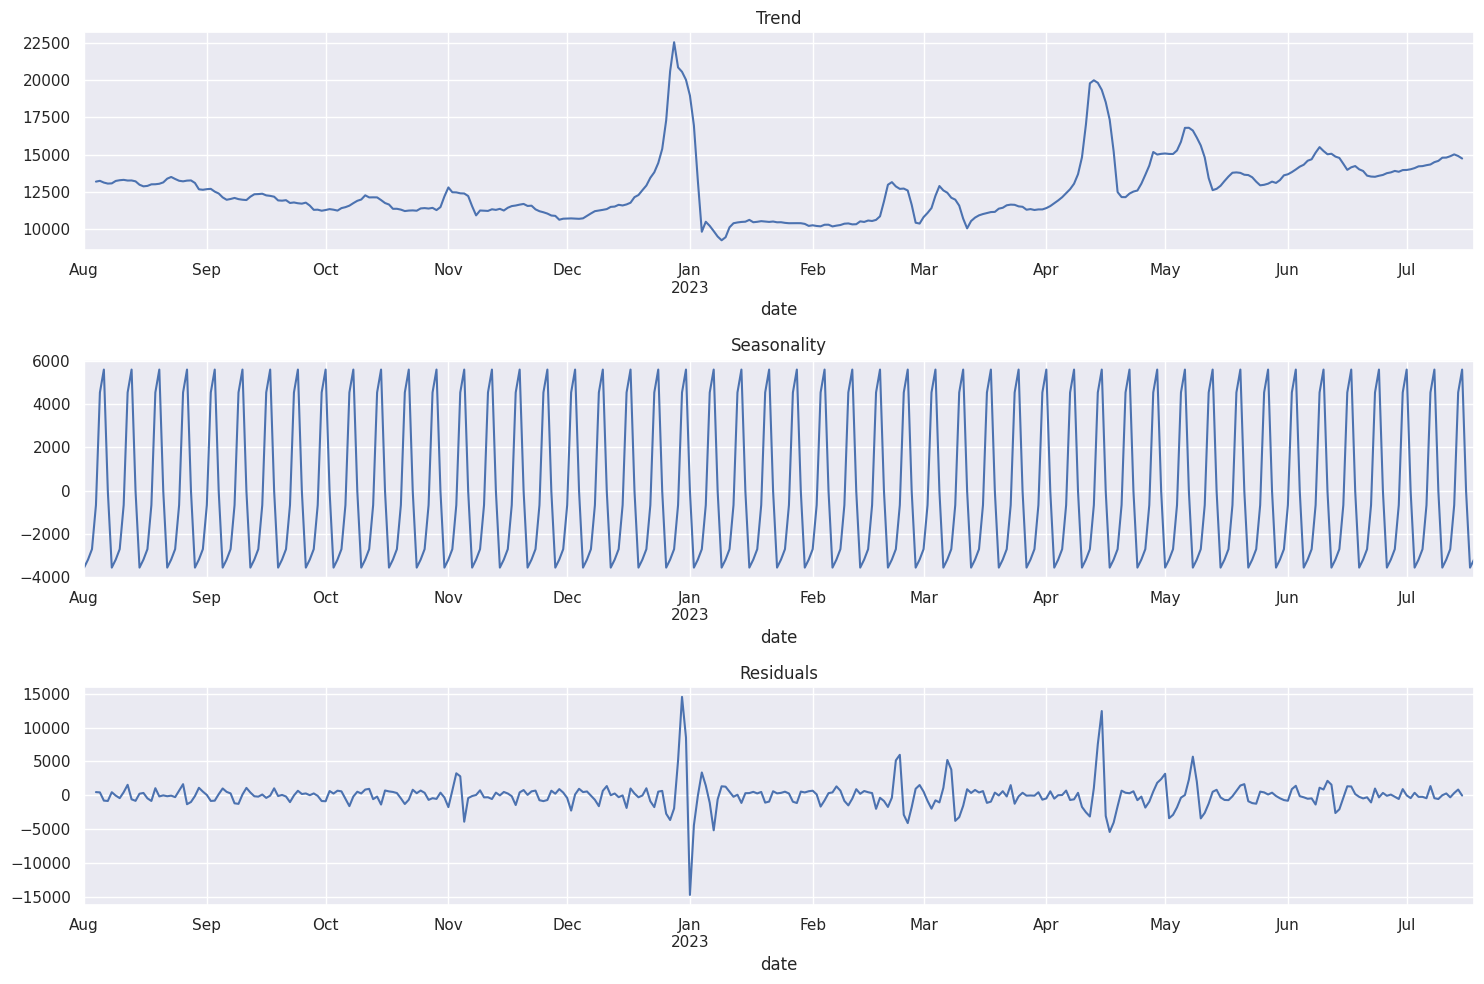

In [47]:
decomposed_units = seasonal_decompose(total['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

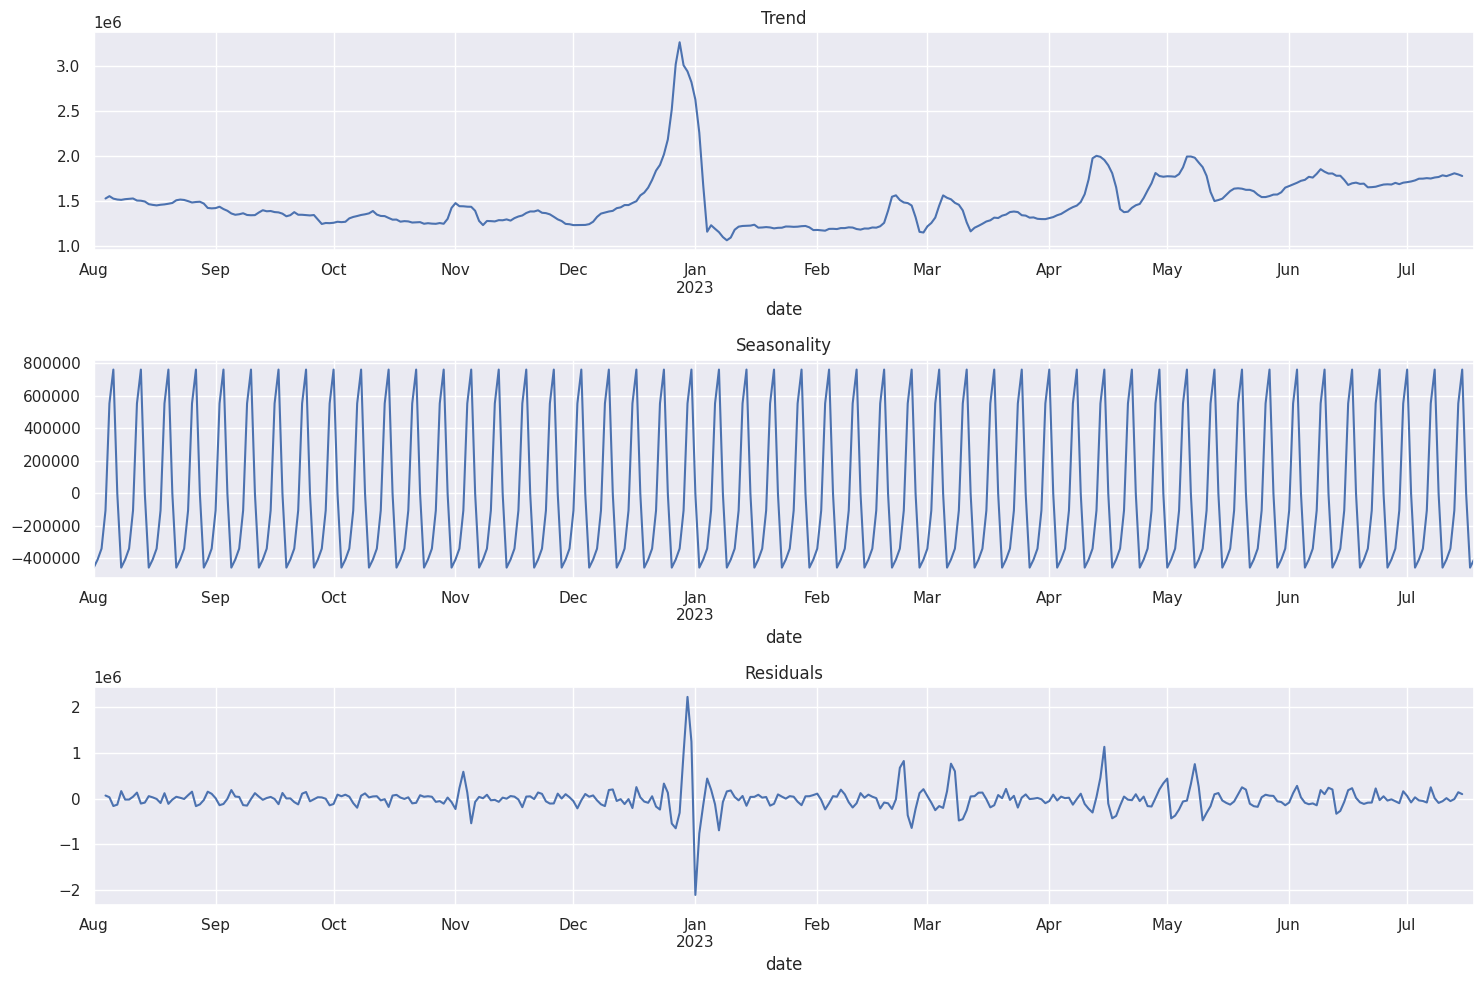

In [48]:
decomposed_rub = seasonal_decompose(total['pr_sales_in_rub'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_rub.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_rub.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_rub.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Сезоннось и тренд за две недели

In [50]:
data_week = total['pr_sales_in_rub']
data_week = data_week['2023-06-24':'2023-07-11']

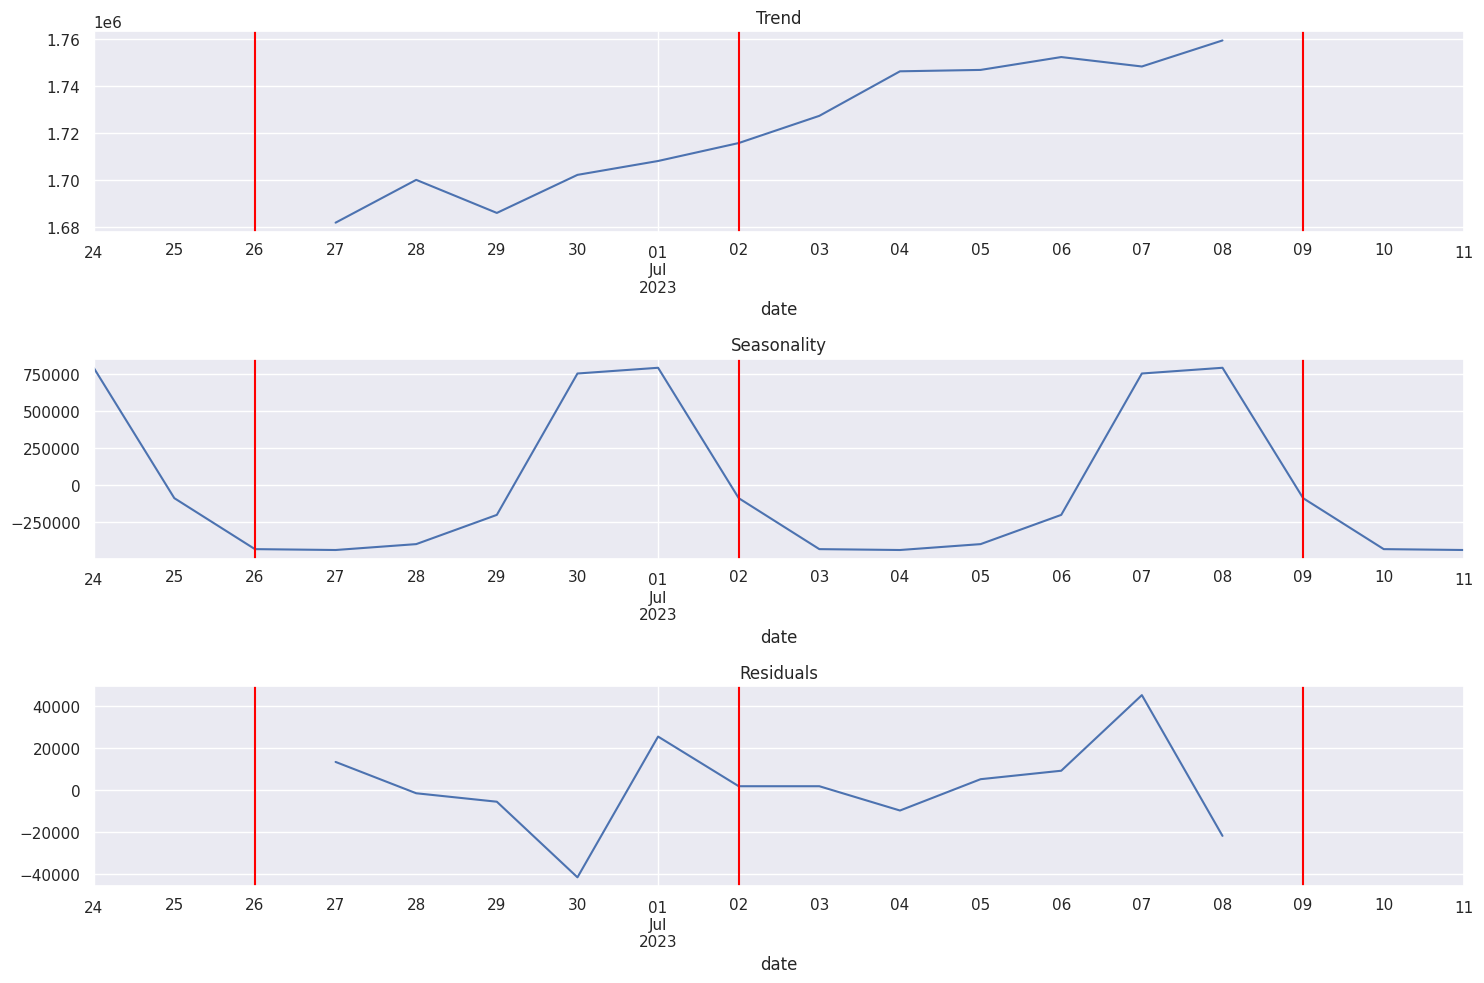

In [51]:
decomposed_week = seasonal_decompose(data_week)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

In [52]:
data_week_1 = total['pr_sales_in_rub']
data_week_1 = data_week_1['2023-04-02':'2023-04-17']

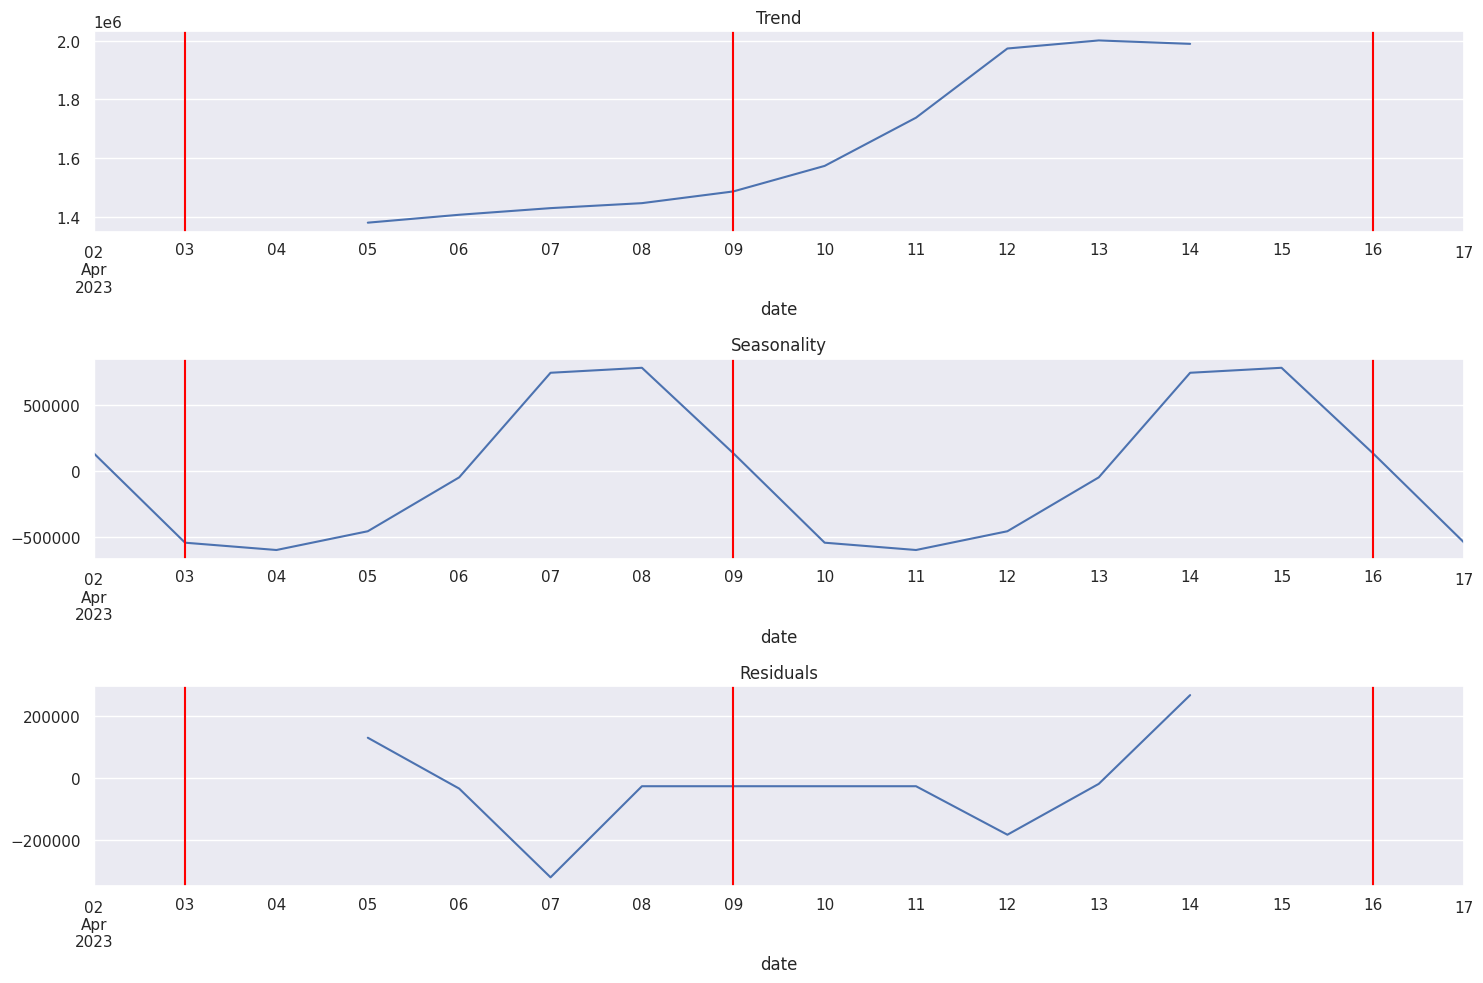

In [53]:
decomposed_week_1 = seasonal_decompose(data_week_1)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_week_1.trend.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week_1.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week_1.resid.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

**Вывод:**
- На графике тренда видим, что продажи растут в дни государственных праздников: Новый год, 23 февраля, 8 марта, майские праздники, 12 июня.
- Так же летом продажи выше, чем в остальные времена года.
- Продажи резко растут в пятницу и субботу, в воскресенье начинают падать в течении недели спрос маленький. Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### Проверка на стационарность

In [55]:
p_value = adfuller(total['pr_sales_in_units'])[1]
print('p =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по расширеннему тесту Дики-Фуллера')

p = 0.014722641217042629
Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера


#### Выводы
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной 'pr_sales_in_units' отличается от нормального.
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены сильно коррелированные столбцы.
- Данные были ресемплированы по одному дню.
- Проанализированы данные по дням недели.
- Данные разложены на три составляющие: сезонность, тренд и остаток.
- Временной ряд стационарен.